In [1]:
import sys
print(sys.executable)

c:\Users\slab\.conda\envs\slab\python.exe


In [2]:
import _ssl

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import yaml
from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict
import qutip as qt
import time 
import matplotlib.pyplot as plt

# from TomoAnalysis import TomoAnalysis
from TomoILC import TomoILC 
from tqdm import tqdm_notebook as tqdm
%matplotlib widget

plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
plt.rcParams['animation.html'] = 'jshtml'

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A
imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experi

In [4]:
from TomoAnalysis import TomoAnalysis
from TomoILC import TomoILC 

# Parameters

In [5]:
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)

with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [6]:
pulse_filename = yaml_cfg.device.qubit.pulses.pulse_pp.filename
pulse_filepath = os.path.join(os.getcwd(), pulse_filename + '.npz')
pulse_IQ = dict() # open file
with np.load(pulse_filepath) as npzfile:
    for key in npzfile.keys():
        pulse_IQ.update({key:npzfile[key]})

In [7]:
pulse_IQ.keys()

dict_keys(['times', 'I_0', 'Q_0', 'I_1', 'Q_1'])

In [8]:
pulse_filename

psi_str = pulse_filename.split('_')[-1] 
q0 = psi_str[0]
q1 = psi_str[1]

# define the psi_ideal 

if q0 =='0':
    psi0 = qt.basis(2,0)
elif q0 == '1':
    psi0 = qt.basis(2,1)
elif q0 == '+':
    psi0 = (qt.basis(2,0) + qt.basis(2,1)).unit()

if q1 =='0':
    psi1 = qt.basis(2,0)
elif q1 == '1':
    psi1 = qt.basis(2,1)
elif q1 == '+':
    psi1 = (qt.basis(2,0) + qt.basis(2,1)).unit()
    
psi_ideal = qt.tensor(psi0, psi1)
rho_ideal = psi_ideal * psi_ideal.dag()

In [9]:
tomo_ILC = TomoILC(
    IQ_pulse_seed=pulse_IQ, 
    gains_filename=pulse_filename, 
    nb_qubits=2, 
    n_shot_calib=4000, 
    n_shot_tomo=4000, 
    qubit_drive=[0, 1],
    debug=False
)

KeyError: 'Qick187'

# 2D map vs amplitude

In [11]:
amp_q0_vec = np.linspace(0.99, 1.01, 3)
amp_q1_vec = np.linspace(0.99, 1.01, 3)
# create a list of pulse dict rescaled by the amplitude
pulse_IQ_rescaled = dict()

for amp_q0 in amp_q0_vec:
    for amp_q1 in amp_q1_vec:
        pulse_IQ_rescaled.update({
            f'{amp_q0}_{amp_q1}': {
                'times': pulse_IQ['times'],
                'I_0': pulse_IQ['I_0']*amp_q0,
                'Q_0': pulse_IQ['Q_0']*amp_q0,
                'I_1': pulse_IQ['I_1']*amp_q1,
                'Q_1': pulse_IQ['Q_1']*amp_q1,
            }
        })

In [12]:
# loop over the rescaled pulses

rho_dict = {}
fidelity_dict = {}
for key, pulse in pulse_IQ_rescaled.items():
    print(f'Running ILC for pulse {key}')
    rho = tomo_ILC.get_tomo_results(pulse)
    rho = qt.Qobj(rho)
    rho.dims = rho_ideal.dims
    fidelity = qt.fidelity(rho, rho_ideal)
    
    rho_dict[key] = rho
    fidelity_dict[key] = fidelity

Running ILC for pulse 0.99_0.99
1.4766247272491455
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 75.80947618452306 	 angle (deg): -166.1644517622392 	 threshold ge: 271.3562025305197
Qubit (1)
ge fidelity (%): 64.025 	 angle (deg): 99.24276405173876 	 threshold ge: 424.7758447081735
thresholds=[271.3562025305197, 424.7758447081735, 0, 0],
angles=[-166.1644517622392, 99.24276405173876, 0, 0],
ge_avgs=[[-160.62401882595486, -168.40305495876737, -520.6244698350695, -75.74818429904512], [105.804689453125, -311.16536507161464, 67.8651258951823, -560.4218952636719], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[3116, 566, 255, 63], [701, 2921, 110, 268], [548, 108, 2676, 668], [184, 426, 579, 2811]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

TypeError: __init__() got an unexpected keyword argument 'tomo_qubits'

In [ ]:
# plot the fidelity as a function of the pulse amplitude

import matplotlib.pyplot as plt

fidelity_mat = np.zeros((len(amp_q0_vec), len(amp_q1_vec)))
for i, amp_q0 in enumerate(amp_q0_vec):
    for j, amp_q1 in enumerate(amp_q1_vec):
        key = f'{amp_q0}_{amp_q1}'
        fidelity_mat[i,j] = fidelity_dict[key]
        
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.imshow(fidelity_mat, extent=[amp_q0_vec[0], amp_q0_vec[-1], amp_q1_vec[0], amp_q1_vec[-1]])

# add the colorbar ranging from 0.9 to 1 

plt.colorbar(im, ax=ax)

In [154]:
tomo_analysis = TomoAnalysis(nb_qubits=2,
                             tomo_qubits=[0, 1],
                             rfsoc_config=tomo_ILC.rfsoc_config)                        

In [ ]:
# plot the best fidelity

max_fidelity = np.max(fidelity_mat)
max_idx = np.where(fidelity_mat == max_fidelity)
best_amp_q0 = amp_q0_vec[max_idx[0][0]]
best_amp_q1 = amp_q1_vec[max_idx[1][0]]
best_key = f'{best_amp_q0}_{best_amp_q1}'
rho = rho_dict[best_key]


tomo_analysis.show_plot_rho_2d(rho,rho_id=rho_ideal.full(), title='Tomo ILC')

# Measure the fidelity versus time

In [11]:
max_time = 60*60*3 # seconds

time_vec = []
fidelity_vec = []
start_time = time.time()

tomo_ILC = TomoILC(
    IQ_pulse_seed=pulse_IQ, 
    gains_filename=pulse_filename, 
    nb_qubits=2, 
    n_shot_calib=20000, 
    n_shot_tomo=20000, 
    qubit_drive=[0, 1],
    time_calib=60*20,
    debug=False
)



Text(0, 0.5, 'Fidelity')

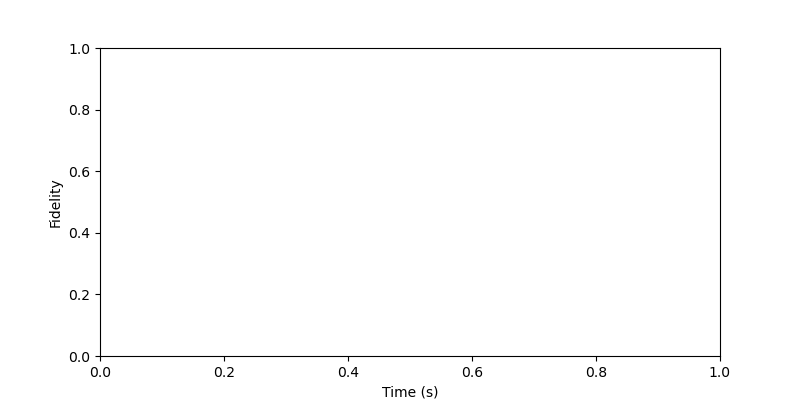

In [241]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.set_xlabel('Time (s)')
ax.set_ylabel('Fidelity')

In [12]:
while time.time() - start_time < max_time:
    rho = tomo_ILC.get_tomo_results(pulse_IQ, ZZ_correction=True)
    rho = qt.Qobj(rho)
    rho.dims = rho_ideal.dims
    fidelity = qt.fidelity(rho, rho_ideal)**2
    
    time_vec.append(time.time() - start_time)
    fidelity_vec.append(fidelity)    
    
    ax.clear()
    ax.plot(time_vec, fidelity_vec, 'o-')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Fidelity')
    fig.canvas.draw()

5.96037483215332
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [243]:
shots = tomo_ILC.tomoExpt.data['counts_tomo_gains'][0][0]
calib_shots = tomo_ILC.tomoExpt.data['counts_calib']

rho = tomo_analysis.get_rho_from_counts(shots, calib_shots)

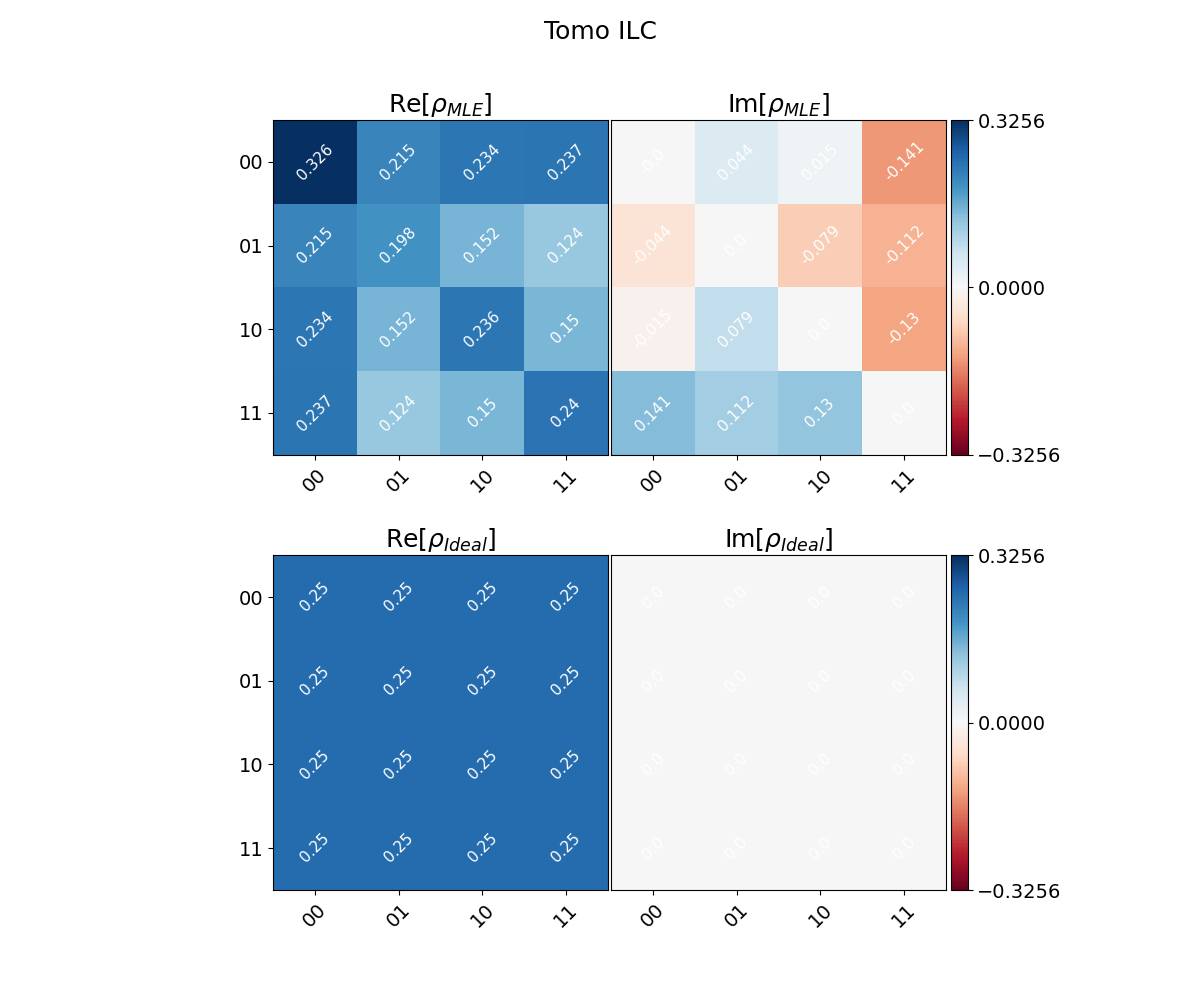

In [244]:
# plot the best fidelity

tomo_analysis.show_plot_rho_2d(rho,rho_id=rho_ideal.full(), title='Tomo ILC')

In [ ]:
rho = tomo_analysis.get_rho_from_counts(shots, calib_shots)
tomo_analysis.show_plot_rho_2d(rho,rho_id=rho_ideal.full(), title='Tomo ILC')

In [ ]:
tomo_ILC.evolv_mat

# Measurement of the fidelity fluctuation versus shots

In [25]:
shot_vec = np.array([1000,  5000, 10000, 20000, 50000, 100000])
nb_measurment = 20
fidelity_vec = np.zeros((len(shot_vec), nb_measurment))

In [29]:
for i, shots in tqdm(enumerate(shot_vec)):
    
    tomo_ILC = TomoILC(
        IQ_pulse_seed=pulse_IQ, 
        gains_filename=pulse_filename, 
        nb_qubits=2, 
        n_shot_calib=shots, 
        n_shot_tomo=shots, 
        qubit_drive=[0, 1],
        tomo_qubits=[0 ,2],
        time_calib=60*10,
        debug=False
    )
    
    for j in range(nb_measurment):
        
        rho = tomo_ILC.get_tomo_results(pulse_IQ, ZZ_correction=False)
        rho = qt.Qobj(rho)
        rho.dims = rho_ideal.dims
        fidelity = qt.fidelity(rho, rho_ideal)**2
        
        fidelity_vec[i,j] = fidelity


Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
 C:\Users\slab\AppData\Local\Temp\ipykernel_12924\1449733536.py: 1

0it [00:00, ?it/s]

0.6624648571014404
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 82.19999999999999 	 angle (deg): 108.1592086482249 	 threshold ge: 262.5260383340367
Qubit (2)
ge fidelity (%): 84.34217108554277 	 angle (deg): 176.54828227288476 	 threshold ge: 526.6744392914735
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[151.60121809895833, -168.17153472222225, 21.491721571180555, -548.40348828125], array([0., 0., 0., 0.]), [-287.01199283854163, -78.8366328125, -784.2658190104166, -98.15888216145834], array([0., 0., 0., 0.])],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

9.008800983428955
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

14.584293842315674
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

20.11250877380371
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

25.618967294692993
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

31.217790842056274
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

36.96940088272095
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

42.48577260971069
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

48.15087652206421
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

53.71127700805664
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

59.18806791305542
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

64.68577766418457
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

70.19017028808594
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

75.95966815948486
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

81.45999717712402
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

87.20213055610657
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

92.70976948738098
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

98.2571165561676
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

103.84866857528687
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

109.42779231071472
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[262.5260383340367, 0, 526.6744392914735, 0],
angles=[108.1592086482249, 0, 176.54828227288476, 0],
ge_avgs=[[ 151.6012181  -168.17153472   21.49172157 -548.40348828]
 [   0.            0.            0.            0.        ]
 [-287.01199284  -78.83663281 -784.26581901  -98.15888216]
 [   0.            0.            0.            0.        ]],
counts_calib=[[871, 63, 59, 7], [84, 834, 5, 77], [112, 6, 822, 60], [7, 110, 60, 823]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.6031539440155029
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.18 	 angle (deg): 107.8730395697497 	 threshold ge: 286.5397788675913
Qubit (2)
ge fidelity (%): 85.88 	 angle (deg): 177.93264145833504 	 threshold ge: 535.7108534528892
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[144.52298480902778, -182.9435375, 24.319591319444445, -553.7549354166666], array([0., 0., 0., 0.]), [-283.201349609375, -76.31983203125, -792.5367259114583, -91.46732408854167], array([0., 0., 0., 0.])],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

33.10832357406616
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

55.58064150810242
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

78.276442527771
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

101.01275658607483
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

123.86570620536804
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

146.59558200836182
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

169.30637788772583
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

191.94460201263428
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

214.68285870552063
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

237.37552523612976
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

260.0640950202942
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

282.7678110599518
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

305.5233497619629
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

328.23892402648926
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

350.9091281890869
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

373.59869289398193
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

396.0896713733673
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

418.8238468170166
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

441.3899931907654
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.5397788675913, 0, 535.7108534528892, 0],
angles=[107.8730395697497, 0, 177.93264145833504, 0],
ge_avgs=[[ 144.52298481 -182.9435375    24.31959132 -553.75493542]
 [   0.            0.            0.            0.        ]
 [-283.20134961  -76.31983203 -792.53672591  -91.46732409]
 [   0.            0.            0.            0.        ]],
counts_calib=[[4267, 274, 436, 23], [386, 4187, 32, 395], [594, 47, 4072, 287], [37, 634, 375, 3954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.6192567348480225
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 76.74767476747675 	 angle (deg): 104.84496685962073 	 threshold ge: 287.8405863928386
Qubit (2)
ge fidelity (%): 85.5142757137857 	 angle (deg): -177.40860881778494 	 threshold ge: 538.9847183091038
thresholds=[287.8405863928386, 0, 538.9847183091038, 0],
angles=[104.84496685962073, 0, -177.40860881778494, 0],
ge_avgs=[[160.86246751302085, -173.54737628038194, 60.45296961805556, -545.5607557291667], array([0., 0., 0., 0.]), [-293.6551388671875, -57.34626223958334, -789.8586638020832, -34.85032350260417], array([0., 0., 0., 0.])],
counts_calib=[[8564, 525, 853, 58], [772, 8400, 97, 731], [1320, 104, 8065, 511], [127, 1299, 704, 7870]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

63.75641894340515
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[287.8405863928386, 0, 538.9847183091038, 0],
angles=[104.84496685962073, 0, -177.40860881778494, 0],
ge_avgs=[[ 160.86246751 -173.54737628   60.45296962 -545.56075573]
 [   0.            0.            0.            0.        ]
 [-293.65513887  -57.34626224 -789.8586638   -34.8503235 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8564, 525, 853, 58], [772, 8400, 97, 731], [1320, 104, 8065, 511], [127, 1299, 704, 7870]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

107.65991306304932
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[287.8405863928386, 0, 538.9847183091038, 0],
angles=[104.84496685962073, 0, -177.40860881778494, 0],
ge_avgs=[[ 160.86246751 -173.54737628   60.45296962 -545.56075573]
 [   0.            0.            0.            0.        ]
 [-293.65513887  -57.34626224 -789.8586638   -34.8503235 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8564, 525, 853, 58], [772, 8400, 97, 731], [1320, 104, 8065, 511], [127, 1299, 704, 7870]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

151.3407711982727
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[287.8405863928386, 0, 538.9847183091038, 0],
angles=[104.84496685962073, 0, -177.40860881778494, 0],
ge_avgs=[[ 160.86246751 -173.54737628   60.45296962 -545.56075573]
 [   0.            0.            0.            0.        ]
 [-293.65513887  -57.34626224 -789.8586638   -34.8503235 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8564, 525, 853, 58], [772, 8400, 97, 731], [1320, 104, 8065, 511], [127, 1299, 704, 7870]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

195.01722931861877
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[287.8405863928386, 0, 538.9847183091038, 0],
angles=[104.84496685962073, 0, -177.40860881778494, 0],
ge_avgs=[[ 160.86246751 -173.54737628   60.45296962 -545.56075573]
 [   0.            0.            0.            0.        ]
 [-293.65513887  -57.34626224 -789.8586638   -34.8503235 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8564, 525, 853, 58], [772, 8400, 97, 731], [1320, 104, 8065, 511], [127, 1299, 704, 7870]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

238.7047896385193
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[287.8405863928386, 0, 538.9847183091038, 0],
angles=[104.84496685962073, 0, -177.40860881778494, 0],
ge_avgs=[[ 160.86246751 -173.54737628   60.45296962 -545.56075573]
 [   0.            0.            0.            0.        ]
 [-293.65513887  -57.34626224 -789.8586638   -34.8503235 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8564, 525, 853, 58], [772, 8400, 97, 731], [1320, 104, 8065, 511], [127, 1299, 704, 7870]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

282.3787610530853
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[287.8405863928386, 0, 538.9847183091038, 0],
angles=[104.84496685962073, 0, -177.40860881778494, 0],
ge_avgs=[[ 160.86246751 -173.54737628   60.45296962 -545.56075573]
 [   0.            0.            0.            0.        ]
 [-293.65513887  -57.34626224 -789.8586638   -34.8503235 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8564, 525, 853, 58], [772, 8400, 97, 731], [1320, 104, 8065, 511], [127, 1299, 704, 7870]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

325.9785306453705
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[287.8405863928386, 0, 538.9847183091038, 0],
angles=[104.84496685962073, 0, -177.40860881778494, 0],
ge_avgs=[[ 160.86246751 -173.54737628   60.45296962 -545.56075573]
 [   0.            0.            0.            0.        ]
 [-293.65513887  -57.34626224 -789.8586638   -34.8503235 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8564, 525, 853, 58], [772, 8400, 97, 731], [1320, 104, 8065, 511], [127, 1299, 704, 7870]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

369.7324194908142
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[287.8405863928386, 0, 538.9847183091038, 0],
angles=[104.84496685962073, 0, -177.40860881778494, 0],
ge_avgs=[[ 160.86246751 -173.54737628   60.45296962 -545.56075573]
 [   0.            0.            0.            0.        ]
 [-293.65513887  -57.34626224 -789.8586638   -34.8503235 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8564, 525, 853, 58], [772, 8400, 97, 731], [1320, 104, 8065, 511], [127, 1299, 704, 7870]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

413.41130471229553
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[287.8405863928386, 0, 538.9847183091038, 0],
angles=[104.84496685962073, 0, -177.40860881778494, 0],
ge_avgs=[[ 160.86246751 -173.54737628   60.45296962 -545.56075573]
 [   0.            0.            0.            0.        ]
 [-293.65513887  -57.34626224 -789.8586638   -34.8503235 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8564, 525, 853, 58], [772, 8400, 97, 731], [1320, 104, 8065, 511], [127, 1299, 704, 7870]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

457.0711920261383
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[287.8405863928386, 0, 538.9847183091038, 0],
angles=[104.84496685962073, 0, -177.40860881778494, 0],
ge_avgs=[[ 160.86246751 -173.54737628   60.45296962 -545.56075573]
 [   0.            0.            0.            0.        ]
 [-293.65513887  -57.34626224 -789.8586638   -34.8503235 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8564, 525, 853, 58], [772, 8400, 97, 731], [1320, 104, 8065, 511], [127, 1299, 704, 7870]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

500.7980098724365
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[287.8405863928386, 0, 538.9847183091038, 0],
angles=[104.84496685962073, 0, -177.40860881778494, 0],
ge_avgs=[[ 160.86246751 -173.54737628   60.45296962 -545.56075573]
 [   0.            0.            0.            0.        ]
 [-293.65513887  -57.34626224 -789.8586638   -34.8503235 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8564, 525, 853, 58], [772, 8400, 97, 731], [1320, 104, 8065, 511], [127, 1299, 704, 7870]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

544.4751110076904
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[287.8405863928386, 0, 538.9847183091038, 0],
angles=[104.84496685962073, 0, -177.40860881778494, 0],
ge_avgs=[[ 160.86246751 -173.54737628   60.45296962 -545.56075573]
 [   0.            0.            0.            0.        ]
 [-293.65513887  -57.34626224 -789.8586638   -34.8503235 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8564, 525, 853, 58], [772, 8400, 97, 731], [1320, 104, 8065, 511], [127, 1299, 704, 7870]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

588.1452674865723
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[287.8405863928386, 0, 538.9847183091038, 0],
angles=[104.84496685962073, 0, -177.40860881778494, 0],
ge_avgs=[[ 160.86246751 -173.54737628   60.45296962 -545.56075573]
 [   0.            0.            0.            0.        ]
 [-293.65513887  -57.34626224 -789.8586638   -34.8503235 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8564, 525, 853, 58], [772, 8400, 97, 731], [1320, 104, 8065, 511], [127, 1299, 704, 7870]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

631.7982552051544
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 75.17 	 angle (deg): 99.3191571268733 	 threshold ge: 286.40736266680847
Qubit (2)
ge fidelity (%): 85.07425371268563 	 angle (deg): -171.86531411093483 	 threshold ge: 532.9754125828335
thresholds=[286.40736266680847, 0, 532.9754125828335, 0],
angles=[99.3191571268733, 0, -171.86531411093483, 0],
ge_avgs=[[171.07056838107638, -158.86880965711805, 110.20748014322918, -526.8600867621528], array([0., 0., 0., 0.]), [-294.4304810546875, -33.39023294270833, -788.4638260416667, 37.30662630208333], array([0., 0., 0., 0.])],
counts_calib=[[8484, 576, 890, 50], [778, 8298, 89, 835], [1440, 120, 7945, 495], [143, 1414, 698, 7745]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

63.05693864822388
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.40736266680847, 0, 532.9754125828335, 0],
angles=[99.3191571268733, 0, -171.86531411093483, 0],
ge_avgs=[[ 171.07056838 -158.86880966  110.20748014 -526.86008676]
 [   0.            0.            0.            0.        ]
 [-294.43048105  -33.39023294 -788.46382604   37.3066263 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8484, 576, 890, 50], [778, 8298, 89, 835], [1440, 120, 7945, 495], [143, 1414, 698, 7745]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

110.35529160499573
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.40736266680847, 0, 532.9754125828335, 0],
angles=[99.3191571268733, 0, -171.86531411093483, 0],
ge_avgs=[[ 171.07056838 -158.86880966  110.20748014 -526.86008676]
 [   0.            0.            0.            0.        ]
 [-294.43048105  -33.39023294 -788.46382604   37.3066263 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8484, 576, 890, 50], [778, 8298, 89, 835], [1440, 120, 7945, 495], [143, 1414, 698, 7745]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

154.05418968200684
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.40736266680847, 0, 532.9754125828335, 0],
angles=[99.3191571268733, 0, -171.86531411093483, 0],
ge_avgs=[[ 171.07056838 -158.86880966  110.20748014 -526.86008676]
 [   0.            0.            0.            0.        ]
 [-294.43048105  -33.39023294 -788.46382604   37.3066263 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8484, 576, 890, 50], [778, 8298, 89, 835], [1440, 120, 7945, 495], [143, 1414, 698, 7745]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

197.75558876991272
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.40736266680847, 0, 532.9754125828335, 0],
angles=[99.3191571268733, 0, -171.86531411093483, 0],
ge_avgs=[[ 171.07056838 -158.86880966  110.20748014 -526.86008676]
 [   0.            0.            0.            0.        ]
 [-294.43048105  -33.39023294 -788.46382604   37.3066263 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8484, 576, 890, 50], [778, 8298, 89, 835], [1440, 120, 7945, 495], [143, 1414, 698, 7745]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

241.43644523620605
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[286.40736266680847, 0, 532.9754125828335, 0],
angles=[99.3191571268733, 0, -171.86531411093483, 0],
ge_avgs=[[ 171.07056838 -158.86880966  110.20748014 -526.86008676]
 [   0.            0.            0.            0.        ]
 [-294.43048105  -33.39023294 -788.46382604   37.3066263 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[8484, 576, 890, 50], [778, 8298, 89, 835], [1440, 120, 7945, 495], [143, 1414, 698, 7745]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.6017866134643555
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 77.42999999999999 	 angle (deg): 97.0038614545386 	 threshold ge: 298.2917536658919
Qubit (2)
ge fidelity (%): 85.22 	 angle (deg): -169.14608005647747 	 threshold ge: 531.7182889924542
thresholds=[298.2917536658919, 0, 531.7182889924542, 0],
angles=[97.0038614545386, 0, -169.14608005647747, 0],
ge_avgs=[[182.00758032769096, -147.56824244791667, 133.25386369357636, -530.4039285807291], array([0., 0., 0., 0.]), [-296.29601380208334, -20.870057682291666, -787.3990986979167, 72.53394222005207], array([0., 0., 0., 0.])],
counts_calib=[[17309, 1141, 1437, 113], [1587, 17010, 130, 1273], [2767, 200, 15943, 1090], [254, 2978, 1439, 15329]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

124.85494136810303
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[298.2917536658919, 0, 531.7182889924542, 0],
angles=[97.0038614545386, 0, -169.14608005647747, 0],
ge_avgs=[[ 182.00758033 -147.56824245  133.25386369 -530.40392858]
 [   0.            0.            0.            0.        ]
 [-296.2960138   -20.87005768 -787.3990987    72.53394222]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17309, 1141, 1437, 113], [1587, 17010, 130, 1273], [2767, 200, 15943, 1090], [254, 2978, 1439, 15329]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

210.92080664634705
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[298.2917536658919, 0, 531.7182889924542, 0],
angles=[97.0038614545386, 0, -169.14608005647747, 0],
ge_avgs=[[ 182.00758033 -147.56824245  133.25386369 -530.40392858]
 [   0.            0.            0.            0.        ]
 [-296.2960138   -20.87005768 -787.3990987    72.53394222]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17309, 1141, 1437, 113], [1587, 17010, 130, 1273], [2767, 200, 15943, 1090], [254, 2978, 1439, 15329]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

297.00897765159607
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[298.2917536658919, 0, 531.7182889924542, 0],
angles=[97.0038614545386, 0, -169.14608005647747, 0],
ge_avgs=[[ 182.00758033 -147.56824245  133.25386369 -530.40392858]
 [   0.            0.            0.            0.        ]
 [-296.2960138   -20.87005768 -787.3990987    72.53394222]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17309, 1141, 1437, 113], [1587, 17010, 130, 1273], [2767, 200, 15943, 1090], [254, 2978, 1439, 15329]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

383.02788162231445
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[298.2917536658919, 0, 531.7182889924542, 0],
angles=[97.0038614545386, 0, -169.14608005647747, 0],
ge_avgs=[[ 182.00758033 -147.56824245  133.25386369 -530.40392858]
 [   0.            0.            0.            0.        ]
 [-296.2960138   -20.87005768 -787.3990987    72.53394222]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17309, 1141, 1437, 113], [1587, 17010, 130, 1273], [2767, 200, 15943, 1090], [254, 2978, 1439, 15329]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

469.0803871154785
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[298.2917536658919, 0, 531.7182889924542, 0],
angles=[97.0038614545386, 0, -169.14608005647747, 0],
ge_avgs=[[ 182.00758033 -147.56824245  133.25386369 -530.40392858]
 [   0.            0.            0.            0.        ]
 [-296.2960138   -20.87005768 -787.3990987    72.53394222]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17309, 1141, 1437, 113], [1587, 17010, 130, 1273], [2767, 200, 15943, 1090], [254, 2978, 1439, 15329]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

555.0601506233215
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[298.2917536658919, 0, 531.7182889924542, 0],
angles=[97.0038614545386, 0, -169.14608005647747, 0],
ge_avgs=[[ 182.00758033 -147.56824245  133.25386369 -530.40392858]
 [   0.            0.            0.            0.        ]
 [-296.2960138   -20.87005768 -787.3990987    72.53394222]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17309, 1141, 1437, 113], [1587, 17010, 130, 1273], [2767, 200, 15943, 1090], [254, 2978, 1439, 15329]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

641.1469829082489
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.86 	 angle (deg): 90.44912122381663 	 threshold ge: 301.0049155063235
Qubit (2)
ge fidelity (%): 85.3171329283232 	 angle (deg): -163.68552114890252 	 threshold ge: 528.8258323344689
thresholds=[301.0049155063235, 0, 528.8258323344689, 0],
angles=[90.44912122381663, 0, -163.68552114890252, 0],
ge_avgs=[[191.8732441297743, -119.26784599609375, 187.1128000542535, -521.278951421441], array([0., 0., 0., 0.]), [-297.81626748046875, 13.390027408854166, -778.0787215169271, 153.03294166666666], array([0., 0., 0., 0.])],
counts_calib=[[17445, 1255, 1195, 105], [1493, 17111, 115, 1281], [2548, 181, 16105, 1166], [260, 2613, 1462, 15665]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

124.3804702758789
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[301.0049155063235, 0, 528.8258323344689, 0],
angles=[90.44912122381663, 0, -163.68552114890252, 0],
ge_avgs=[[ 191.87324413 -119.267846    187.11280005 -521.27895142]
 [   0.            0.            0.            0.        ]
 [-297.81626748   13.39002741 -778.07872152  153.03294167]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17445, 1255, 1195, 105], [1493, 17111, 115, 1281], [2548, 181, 16105, 1166], [260, 2613, 1462, 15665]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

210.43113541603088
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[301.0049155063235, 0, 528.8258323344689, 0],
angles=[90.44912122381663, 0, -163.68552114890252, 0],
ge_avgs=[[ 191.87324413 -119.267846    187.11280005 -521.27895142]
 [   0.            0.            0.            0.        ]
 [-297.81626748   13.39002741 -778.07872152  153.03294167]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17445, 1255, 1195, 105], [1493, 17111, 115, 1281], [2548, 181, 16105, 1166], [260, 2613, 1462, 15665]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

296.58978962898254
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[301.0049155063235, 0, 528.8258323344689, 0],
angles=[90.44912122381663, 0, -163.68552114890252, 0],
ge_avgs=[[ 191.87324413 -119.267846    187.11280005 -521.27895142]
 [   0.            0.            0.            0.        ]
 [-297.81626748   13.39002741 -778.07872152  153.03294167]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17445, 1255, 1195, 105], [1493, 17111, 115, 1281], [2548, 181, 16105, 1166], [260, 2613, 1462, 15665]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

382.64452147483826
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[301.0049155063235, 0, 528.8258323344689, 0],
angles=[90.44912122381663, 0, -163.68552114890252, 0],
ge_avgs=[[ 191.87324413 -119.267846    187.11280005 -521.27895142]
 [   0.            0.            0.            0.        ]
 [-297.81626748   13.39002741 -778.07872152  153.03294167]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17445, 1255, 1195, 105], [1493, 17111, 115, 1281], [2548, 181, 16105, 1166], [260, 2613, 1462, 15665]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

468.7361273765564
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[301.0049155063235, 0, 528.8258323344689, 0],
angles=[90.44912122381663, 0, -163.68552114890252, 0],
ge_avgs=[[ 191.87324413 -119.267846    187.11280005 -521.27895142]
 [   0.            0.            0.            0.        ]
 [-297.81626748   13.39002741 -778.07872152  153.03294167]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17445, 1255, 1195, 105], [1493, 17111, 115, 1281], [2548, 181, 16105, 1166], [260, 2613, 1462, 15665]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

554.8344924449921
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[301.0049155063235, 0, 528.8258323344689, 0],
angles=[90.44912122381663, 0, -163.68552114890252, 0],
ge_avgs=[[ 191.87324413 -119.267846    187.11280005 -521.27895142]
 [   0.            0.            0.            0.        ]
 [-297.81626748   13.39002741 -778.07872152  153.03294167]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17445, 1255, 1195, 105], [1493, 17111, 115, 1281], [2548, 181, 16105, 1166], [260, 2613, 1462, 15665]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

640.9259021282196
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 81.0 	 angle (deg): 84.8149540750609 	 threshold ge: 289.1494643283736
Qubit (2)
ge fidelity (%): 84.66 	 angle (deg): -157.40557342979088 	 threshold ge: 533.1583816738495
thresholds=[289.1494643283736, 0, 533.1583816738495, 0],
angles=[84.8149540750609, 0, -157.40557342979088, 0],
ge_avgs=[[203.28539958767362, -96.77633588324653, 240.9712731987847, -502.54959816623267], array([0., 0., 0., 0.]), [-296.37628261718754, 40.33273929036458, -754.3640299804688, 232.236496875], array([0., 0., 0., 0.])],
counts_calib=[[17391, 1268, 1259, 82], [1626, 17052, 105, 1217], [2291, 171, 16382, 1156], [236, 2412, 1502, 15850]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

124.33740520477295
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[289.1494643283736, 0, 533.1583816738495, 0],
angles=[84.8149540750609, 0, -157.40557342979088, 0],
ge_avgs=[[ 203.28539959  -96.77633588  240.9712732  -502.54959817]
 [   0.            0.            0.            0.        ]
 [-296.37628262   40.33273929 -754.36402998  232.23649688]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17391, 1268, 1259, 82], [1626, 17052, 105, 1217], [2291, 171, 16382, 1156], [236, 2412, 1502, 15850]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

210.4622414112091
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[289.1494643283736, 0, 533.1583816738495, 0],
angles=[84.8149540750609, 0, -157.40557342979088, 0],
ge_avgs=[[ 203.28539959  -96.77633588  240.9712732  -502.54959817]
 [   0.            0.            0.            0.        ]
 [-296.37628262   40.33273929 -754.36402998  232.23649688]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17391, 1268, 1259, 82], [1626, 17052, 105, 1217], [2291, 171, 16382, 1156], [236, 2412, 1502, 15850]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

296.64278292655945
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[289.1494643283736, 0, 533.1583816738495, 0],
angles=[84.8149540750609, 0, -157.40557342979088, 0],
ge_avgs=[[ 203.28539959  -96.77633588  240.9712732  -502.54959817]
 [   0.            0.            0.            0.        ]
 [-296.37628262   40.33273929 -754.36402998  232.23649688]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17391, 1268, 1259, 82], [1626, 17052, 105, 1217], [2291, 171, 16382, 1156], [236, 2412, 1502, 15850]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

382.73608469963074
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[289.1494643283736, 0, 533.1583816738495, 0],
angles=[84.8149540750609, 0, -157.40557342979088, 0],
ge_avgs=[[ 203.28539959  -96.77633588  240.9712732  -502.54959817]
 [   0.            0.            0.            0.        ]
 [-296.37628262   40.33273929 -754.36402998  232.23649688]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17391, 1268, 1259, 82], [1626, 17052, 105, 1217], [2291, 171, 16382, 1156], [236, 2412, 1502, 15850]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

468.8196346759796
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[289.1494643283736, 0, 533.1583816738495, 0],
angles=[84.8149540750609, 0, -157.40557342979088, 0],
ge_avgs=[[ 203.28539959  -96.77633588  240.9712732  -502.54959817]
 [   0.            0.            0.            0.        ]
 [-296.37628262   40.33273929 -754.36402998  232.23649688]
 [   0.            0.            0.            0.        ]],
counts_calib=[[17391, 1268, 1259, 82], [1626, 17052, 105, 1217], [2291, 171, 16382, 1156], [236, 2412, 1502, 15850]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.6434757709503174
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 77.35600000000001 	 angle (deg): 79.39532861248583 	 threshold ge: 292.9465514651779
Qubit (2)
ge fidelity (%): 85.396 	 angle (deg): -152.01060710461763 	 threshold ge: 529.7916642875549
thresholds=[292.9465514651779, 0, 529.7916642875549, 0],
angles=[79.39532861248583, 0, -152.01060710461763, 0],
ge_avgs=[[213.11516605902779, -86.83413194010416, 286.4788208940972, -470.44326613715276], array([0., 0., 0., 0.]), [-289.84619513020834, 68.0760296484375, -733.1439638541667, 304.44692820312497], array([0., 0., 0., 0.])],
counts_calib=[[42812, 2973, 3943, 272], [3743, 41940, 348, 3969], [6602, 518, 39932, 2948], [602, 7175, 3577, 38646]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

308.64566349983215
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[292.9465514651779, 0, 529.7916642875549, 0],
angles=[79.39532861248583, 0, -152.01060710461763, 0],
ge_avgs=[[ 213.11516606  -86.83413194  286.47882089 -470.44326614]
 [   0.            0.            0.            0.        ]
 [-289.84619513   68.07602965 -733.14396385  304.4469282 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[42812, 2973, 3943, 272], [3743, 41940, 348, 3969], [6602, 518, 39932, 2948], [602, 7175, 3577, 38646]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

521.7932798862457
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[292.9465514651779, 0, 529.7916642875549, 0],
angles=[79.39532861248583, 0, -152.01060710461763, 0],
ge_avgs=[[ 213.11516606  -86.83413194  286.47882089 -470.44326614]
 [   0.            0.            0.            0.        ]
 [-289.84619513   68.07602965 -733.14396385  304.4469282 ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[42812, 2973, 3943, 272], [3743, 41940, 348, 3969], [6602, 518, 39932, 2948], [602, 7175, 3577, 38646]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

734.9859576225281
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.63 	 angle (deg): 73.08789413950652 	 threshold ge: 279.08817589102694
Qubit (2)
ge fidelity (%): 84.82284822848229 	 angle (deg): -146.00200829278367 	 threshold ge: 535.0232615845348
thresholds=[279.08817589102694, 0, 535.0232615845348, 0],
angles=[73.08789413950652, 0, -146.00200829278367, 0],
ge_avgs=[[221.11564782986108, -58.86886469184028, 336.7551363498264, -435.52281934895836], array([0., 0., 0., 0.]), [-281.8405729036458, 102.68795190104169, -692.2627099609375, 379.8254535156251], array([0., 0., 0., 0.])],
counts_calib=[[42868, 2985, 3881, 266], [4031, 42397, 334, 3238], [6122, 473, 40622, 2783], [608, 6834, 3830, 38728]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

308.0046877861023
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[279.08817589102694, 0, 535.0232615845348, 0],
angles=[73.08789413950652, 0, -146.00200829278367, 0],
ge_avgs=[[ 221.11564783  -58.86886469  336.75513635 -435.52281935]
 [   0.            0.            0.            0.        ]
 [-281.8405729   102.6879519  -692.26270996  379.82545352]
 [   0.            0.            0.            0.        ]],
counts_calib=[[42868, 2985, 3881, 266], [4031, 42397, 334, 3238], [6122, 473, 40622, 2783], [608, 6834, 3830, 38728]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

521.3877956867218
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[279.08817589102694, 0, 535.0232615845348, 0],
angles=[73.08789413950652, 0, -146.00200829278367, 0],
ge_avgs=[[ 221.11564783  -58.86886469  336.75513635 -435.52281935]
 [   0.            0.            0.            0.        ]
 [-281.8405729   102.6879519  -692.26270996  379.82545352]
 [   0.            0.            0.            0.        ]],
counts_calib=[[42868, 2985, 3881, 266], [4031, 42397, 334, 3238], [6122, 473, 40622, 2783], [608, 6834, 3830, 38728]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

734.6173124313354
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.562 	 angle (deg): 66.4746746168656 	 threshold ge: 291.4249297780423
Qubit (2)
ge fidelity (%): 84.696 	 angle (deg): -139.38389421221925 	 threshold ge: 530.712262372204
thresholds=[291.4249297780423, 0, 530.712262372204, 0],
angles=[66.4746746168656, 0, -139.38389421221925, 0],
ge_avgs=[[222.87944550347223, -34.69688622395834, 383.1422431944444, -398.3383935546875], array([0., 0., 0., 0.]), [-269.08800251302085, 128.8776782421875, -646.4951800390626, 451.59256598958336], array([0., 0., 0., 0.])],
counts_calib=[[43136, 3014, 3557, 293], [4017, 42266, 347, 3370], [6405, 479, 40185, 2931], [612, 6386, 3545, 39457]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

307.9102032184601
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[291.4249297780423, 0, 530.712262372204, 0],
angles=[66.4746746168656, 0, -139.38389421221925, 0],
ge_avgs=[[ 222.8794455   -34.69688622  383.14224319 -398.33839355]
 [   0.            0.            0.            0.        ]
 [-269.08800251  128.87767824 -646.49518004  451.59256599]
 [   0.            0.            0.            0.        ]],
counts_calib=[[43136, 3014, 3557, 293], [4017, 42266, 347, 3370], [6405, 479, 40185, 2931], [612, 6386, 3545, 39457]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

521.0572018623352
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[291.4249297780423, 0, 530.712262372204, 0],
angles=[66.4746746168656, 0, -139.38389421221925, 0],
ge_avgs=[[ 222.8794455   -34.69688622  383.14224319 -398.33839355]
 [   0.            0.            0.            0.        ]
 [-269.08800251  128.87767824 -646.49518004  451.59256599]
 [   0.            0.            0.            0.        ]],
counts_calib=[[43136, 3014, 3557, 293], [4017, 42266, 347, 3370], [6405, 479, 40185, 2931], [612, 6386, 3545, 39457]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

734.125937461853
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.02079020790208 	 angle (deg): 60.261499589033356 	 threshold ge: 295.6319888232015
Qubit (2)
ge fidelity (%): 84.458 	 angle (deg): -133.61808958495237 	 threshold ge: 522.555139046976
thresholds=[295.6319888232015, 0, 522.555139046976, 0],
angles=[60.261499589033356, 0, -133.61808958495237, 0],
ge_avgs=[[221.6924824522569, -7.540964926215278, 420.39658778645827, -351.21990562065974], array([0., 0., 0., 0.]), [-250.482321171875, 158.93523255208333, -591.2553637369791, 517.5122940104167], array([0., 0., 0., 0.])],
counts_calib=[[43333, 3282, 3128, 257], [3920, 41881, 358, 3841], [6621, 494, 39793, 3092], [620, 6735, 3603, 39042]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

308.24659872055054
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[295.6319888232015, 0, 522.555139046976, 0],
angles=[60.261499589033356, 0, -133.61808958495237, 0],
ge_avgs=[[ 221.69248245   -7.54096493  420.39658779 -351.21990562]
 [   0.            0.            0.            0.        ]
 [-250.48232117  158.93523255 -591.25536374  517.51229401]
 [   0.            0.            0.            0.        ]],
counts_calib=[[43333, 3282, 3128, 257], [3920, 41881, 358, 3841], [6621, 494, 39793, 3092], [620, 6735, 3603, 39042]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

521.3881225585938
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[295.6319888232015, 0, 522.555139046976, 0],
angles=[60.261499589033356, 0, -133.61808958495237, 0],
ge_avgs=[[ 221.69248245   -7.54096493  420.39658779 -351.21990562]
 [   0.            0.            0.            0.        ]
 [-250.48232117  158.93523255 -591.25536374  517.51229401]
 [   0.            0.            0.            0.        ]],
counts_calib=[[43333, 3282, 3128, 257], [3920, 41881, 358, 3841], [6621, 494, 39793, 3092], [620, 6735, 3603, 39042]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

734.4074404239655
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 76.806 	 angle (deg): 53.80291542972197 	 threshold ge: 301.4278187016188
Qubit (2)
ge fidelity (%): 84.82884828848289 	 angle (deg): -127.02170553349622 	 threshold ge: 525.7514449420269
thresholds=[301.4278187016188, 0, 525.7514449420269, 0],
angles=[53.80291542972197, 0, -127.02170553349622, 0],
ge_avgs=[[230.49657006944443, 6.853193420138889, 458.37743345486103, -302.6678349739583], array([0., 0., 0., 0.]), [-233.26001302083336, 186.28690473958332, -531.3082434114583, 582.8717184114582], array([0., 0., 0., 0.])],
counts_calib=[[42424, 3188, 4056, 332], [3831, 42786, 296, 3087], [6738, 477, 39865, 2920], [651, 6955, 3502, 38892]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

307.7901005744934
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[301.4278187016188, 0, 525.7514449420269, 0],
angles=[53.80291542972197, 0, -127.02170553349622, 0],
ge_avgs=[[ 230.49657007    6.85319342  458.37743345 -302.66783497]
 [   0.            0.            0.            0.        ]
 [-233.26001302  186.28690474 -531.30824341  582.87171841]
 [   0.            0.            0.            0.        ]],
counts_calib=[[42424, 3188, 4056, 332], [3831, 42786, 296, 3087], [6738, 477, 39865, 2920], [651, 6955, 3502, 38892]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

520.9989552497864
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[301.4278187016188, 0, 525.7514449420269, 0],
angles=[53.80291542972197, 0, -127.02170553349622, 0],
ge_avgs=[[ 230.49657007    6.85319342  458.37743345 -302.66783497]
 [   0.            0.            0.            0.        ]
 [-233.26001302  186.28690474 -531.30824341  582.87171841]
 [   0.            0.            0.            0.        ]],
counts_calib=[[42424, 3188, 4056, 332], [3831, 42786, 296, 3087], [6738, 477, 39865, 2920], [651, 6955, 3502, 38892]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

734.0513813495636
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.54479544795447 	 angle (deg): 47.35287545283275 	 threshold ge: 287.7851731658124
Qubit (2)
ge fidelity (%): 85.21600000000001 	 angle (deg): -120.98585062849457 	 threshold ge: 530.607853757787
thresholds=[287.7851731658124, 0, 530.607853757787, 0],
angles=[47.35287545283275, 0, -120.98585062849457, 0],
ge_avgs=[[224.17400821180559, 43.88890827690972, 493.28334694878475, -249.2216772048611], array([0., 0., 0., 0.]), [-202.95019332031245, 213.4181226953125, -460.4639545833333, 640.8108978515625], array([0., 0., 0., 0.])],
counts_calib=[[43094, 3055, 3597, 254], [3838, 42784, 278, 3100], [5974, 417, 40810, 2799], [528, 6514, 3560, 39398]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

307.80918312072754
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[287.7851731658124, 0, 530.607853757787, 0],
angles=[47.35287545283275, 0, -120.98585062849457, 0],
ge_avgs=[[ 224.17400821   43.88890828  493.28334695 -249.2216772 ]
 [   0.            0.            0.            0.        ]
 [-202.95019332  213.4181227  -460.46395458  640.81089785]
 [   0.            0.            0.            0.        ]],
counts_calib=[[43094, 3055, 3597, 254], [3838, 42784, 278, 3100], [5974, 417, 40810, 2799], [528, 6514, 3560, 39398]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

521.0397012233734
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[287.7851731658124, 0, 530.607853757787, 0],
angles=[47.35287545283275, 0, -120.98585062849457, 0],
ge_avgs=[[ 224.17400821   43.88890828  493.28334695 -249.2216772 ]
 [   0.            0.            0.            0.        ]
 [-202.95019332  213.4181227  -460.46395458  640.81089785]
 [   0.            0.            0.            0.        ]],
counts_calib=[[43094, 3055, 3597, 254], [3838, 42784, 278, 3100], [5974, 417, 40810, 2799], [528, 6514, 3560, 39398]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

734.4118819236755
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 76.972 	 angle (deg): 40.736465856373364 	 threshold ge: 290.01900776188245
Qubit (2)
ge fidelity (%): 84.812 	 angle (deg): -113.7467199789117 	 threshold ge: 534.7380812606214
thresholds=[290.01900776188245, 0, 534.7380812606214, 0],
angles=[40.736465856373364, 0, -113.7467199789117, 0],
ge_avgs=[[221.75566411024306, 65.350446484375, 512.2747577517362, -185.30084420138888], array([0., 0., 0., 0.]), [-185.335740546875, 234.02564421875, -385.0038555208334, 689.2099254296874], array([0., 0., 0., 0.])],
counts_calib=[[42908, 2980, 3862, 250], [4030, 42022, 351, 3597], [6979, 449, 39866, 2706], [676, 6796, 3549, 38979]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

307.9079451560974
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[290.01900776188245, 0, 534.7380812606214, 0],
angles=[40.736465856373364, 0, -113.7467199789117, 0],
ge_avgs=[[ 221.75566411   65.35044648  512.27475775 -185.3008442 ]
 [   0.            0.            0.            0.        ]
 [-185.33574055  234.02564422 -385.00385552  689.20992543]
 [   0.            0.            0.            0.        ]],
counts_calib=[[42908, 2980, 3862, 250], [4030, 42022, 351, 3597], [6979, 449, 39866, 2706], [676, 6796, 3549, 38979]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.5974700450897217
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 77.37 	 angle (deg): 35.50042898480435 	 threshold ge: 294.81765048040495
Qubit (2)
ge fidelity (%): 85.095 	 angle (deg): -109.06631012204681 	 threshold ge: 538.0649674497877
thresholds=[294.81765048040495, 0, 538.0649674497877, 0],
angles=[35.50042898480435, 0, -109.06631012204681, 0],
ge_avgs=[[212.93502282118055, 85.54075720052084, 527.0443913302952, -139.85527488498266], array([0., 0., 0., 0.]), [-161.1675740299479, 250.70721253255206, -324.27015805989583, 722.9064583789061], array([0., 0., 0., 0.])],
counts_calib=[[86565, 5794, 7138, 503], [7968, 84270, 650, 7112], [14030, 962, 79651, 5357], [1283, 13381, 7482, 77854]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

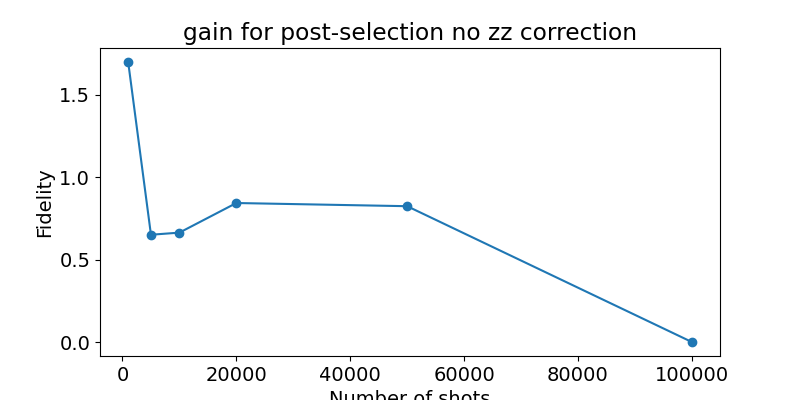

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# ax.errorbar(shot_vec, np.mean(fidelity_vec, axis=1), yerr=np.std(fidelity_vec, axis=1), fmt='o-', zorder=1)
# ax.plot(shot_vec, fidelity_vec, 'o', alpha=0.1, color='black', zorder=0)
ax.plot(shot_vec, np.std(fidelity_vec, axis=1)*100, 'o-', zorder=1)

ax.set_xlabel('Number of shots')
ax.set_ylabel('Fidelity')

title = 'gain for post-selection no zz correction'
ax.set_title(title)

# save 

filename = f'fidelity_vs_shots_{title}.png'

fig.savefig(filename)